# **OBJECT DETECTION MODEL**
  
  By Shreya Tripathi
  
  ---

### First, install the necessary packages

In [1]:
!pip install opencv-python-headless

In [2]:
!pip install matplotlib

### Download YOLOv3 configuration, weights, and coco.names

In [3]:
!wget https://pjreddie.com/media/files/yolov3.weights

--2024-12-17 15:55:29--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  17.5MB/s    in 12s     

2024-12-17 15:55:41 (20.0 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]



In [4]:
!wget https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg


--2024-12-17 15:55:41--  https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8342 (8.1K) [text/plain]
Saving to: ‘yolov3.cfg’

yolov3.cfg          100%[===================>]   8.15K  --.-KB/s    in 0s      

2024-12-17 15:55:42 (48.7 MB/s) - ‘yolov3.cfg’ saved [8342/8342]



In [5]:
!wget https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names

--2024-12-17 15:55:42--  https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 625 [text/plain]
Saving to: ‘coco.names’

coco.names          100%[===================>]     625  --.-KB/s    in 0s      

2024-12-17 15:55:42 (31.8 MB/s) - ‘coco.names’ saved [625/625]



Saving test2.jpg to test2 (1).jpg


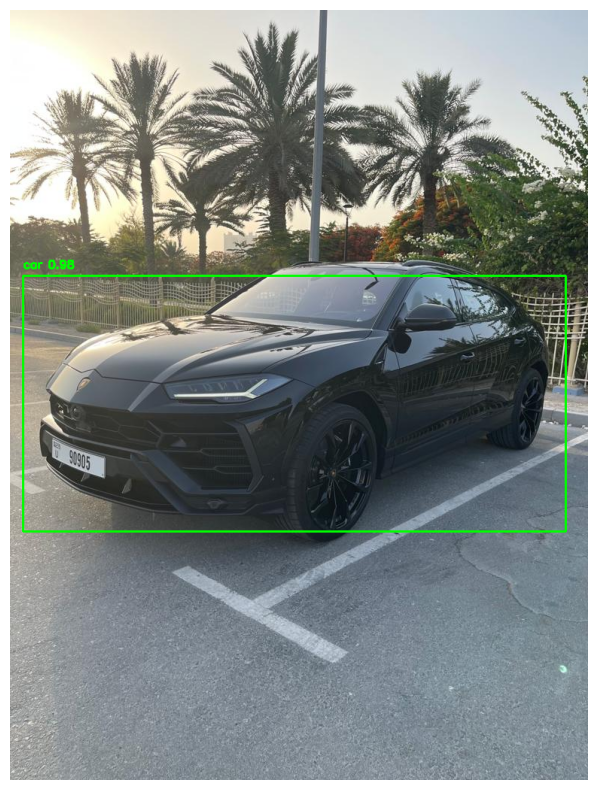

In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# Upload the image file
uploaded = files.upload()

# After uploading, the file should be in the current directory.
# Let's check the uploaded file names.
image_path = list(uploaded.keys())[0]  # Get the file name of the uploaded image

# Load YOLO
yolo_net = cv2.dnn.readNet("yolov3.weights", "yolov3.cfg")
layer_names = yolo_net.getLayerNames()

# Get the output layer names (the layers that produce the final output)
output_layers = [layer_names[i - 1] for i in yolo_net.getUnconnectedOutLayers()]

# Load class names from coco.names
with open("coco.names", "r") as f:
    classes = [line.strip() for line in f.readlines()]

# Load the uploaded image (trial.jpg)
img = cv2.imread(image_path)
if img is None:
    print("Error: Could not load the image.")
else:
    height, width, channels = img.shape

    # Convert image to blob for YOLO model
    blob = cv2.dnn.blobFromImage(img, 0.00392, (416, 416), (0, 0, 0), True, crop=False)

    yolo_net.setInput(blob)
    outs = yolo_net.forward(output_layers)

    # Process the detections
    class_ids = []
    confidences = []
    boxes = []

    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]

            if confidence > 0.5:
                # Get the bounding box coordinates
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)

                # Draw the bounding box on the image
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    # Apply Non-Maximum Suppression to remove overlapping boxes
    indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

    # Draw the detected objects
    for i in range(len(boxes)):
        if i in indices:
            box = boxes[i]
            x, y, w, h = box
            label = str(classes[class_ids[i]])
            confidence = confidences[i]

            # Draw a rectangle around the object
            cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
            cv2.putText(img, f"{label} {confidence:.2f}", (x, y - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Display the resulting image with detections
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()


# **Real time Detection**

In Google Colab, we **cannot directly access the webcam** feed as we would on our local machine, but there is a workaround.

In [41]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


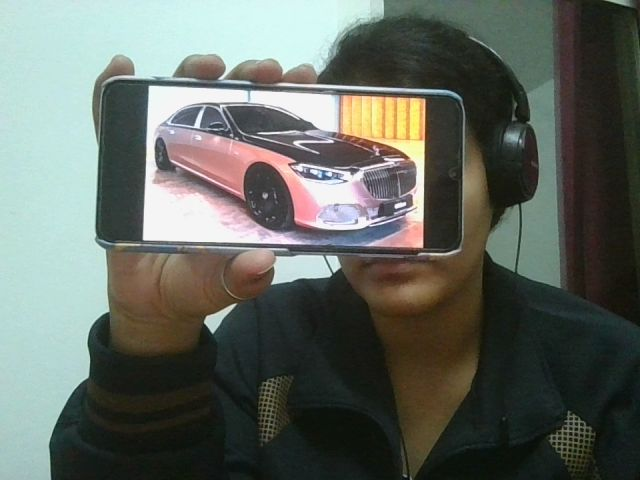

In [52]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

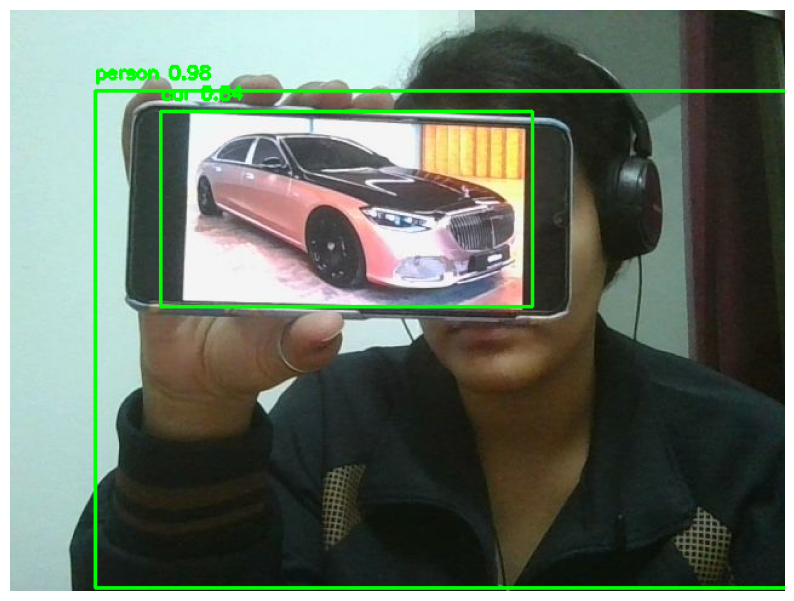

True

In [53]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load YOLO model
yolo_net = cv2.dnn.readNet("yolov3.weights", "yolov3.cfg")
layer_names = yolo_net.getLayerNames()
output_layers = [layer_names[i - 1] for i in yolo_net.getUnconnectedOutLayers()]

# Load class labels (COCO names)
with open("coco.names", "r") as f:
    classes = [line.strip() for line in f.readlines()]

# Load the image (photo.jpg)
img = cv2.imread("photo.jpg")
height, width, channels = img.shape

# Convert the image to a blob for YOLO input
blob = cv2.dnn.blobFromImage(img, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
yolo_net.setInput(blob)
outs = yolo_net.forward(output_layers)

# Post-process the output and draw bounding boxes
class_ids = []
confidences = []
boxes = []

for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]

        if confidence > 0.5:  # Adjust confidence threshold as needed
            center_x = int(detection[0] * width)
            center_y = int(detection[1] * height)
            w = int(detection[2] * width)
            h = int(detection[3] * height)

            # Rectangle coordinates
            x = int(center_x - w / 2)
            y = int(center_y - h / 2)

            boxes.append([x, y, w, h])
            confidences.append(float(confidence))
            class_ids.append(class_id)

# Apply non-maxima suppression to remove redundant boxes
indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

# Draw bounding boxes and labels on the image
for i in range(len(boxes)):
    if i in indices:
        x, y, w, h = boxes[i]
        label = str(classes[class_ids[i]])
        confidence = str(round(confidences[i], 2))

        # Draw the rectangle and the label
        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(img, f"{label} {confidence}", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Convert the image from BGR to RGB (for display in Colab)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display the image with bounding boxes
plt.figure(figsize=(10, 10))
plt.imshow(img_rgb)
plt.axis('off')
plt.show()

# Optionally, save the processed image with bounding boxes
cv2.imwrite("photo_detected.jpg", img)